In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=['pickup_datetime'])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [3]:
df.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count             float64
dtype: object

,missing_value,%
fare_amount,0,0.00
pickup_datetime,0,0.00
pickup_longitude,0,0.00
pickup_latitude,0,0.00
dropoff_longitude,0,0.00
dropoff_latitude,0,0.00
passenger_count,1,0.01


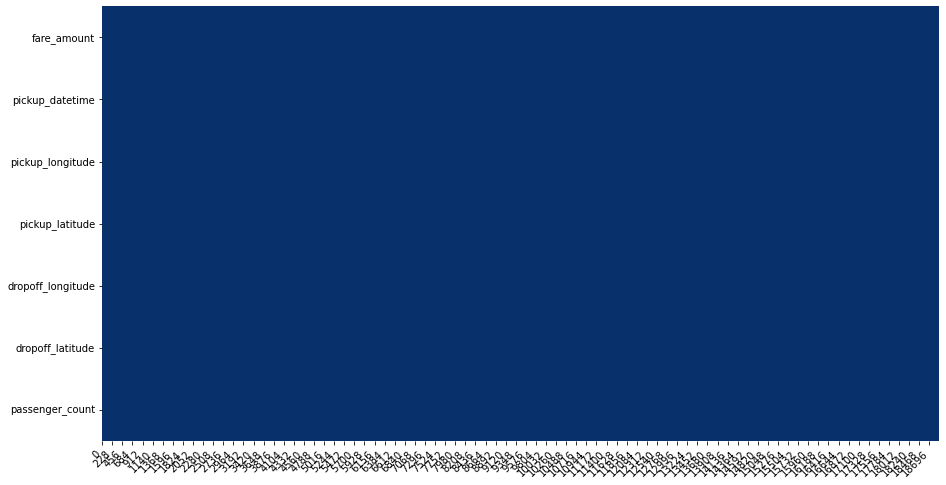

In [4]:
plot_missing_value(df, return_df=True)

In [5]:
df.dropna(inplace=True)

# Extract Time Feature

In [6]:
pickup_dt = df.pickup_datetime.dt

In [7]:
df["hour"] = pickup_dt.hour
df["day"] = pickup_dt.day
df["weekday"] = pickup_dt.weekday
df["weekend"] = (df.weekday >= 5).astype(int)
df["month"] = pickup_dt.month
df["year"] = pickup_dt.year
df.drop(columns=["pickup_datetime"], inplace=True)

In [8]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,weekday,weekend,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,17,15,0,0,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,16,5,1,0,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,0,18,3,0,8,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,4,21,5,1,4,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,7,9,1,0,3,2010


# Extract Distance Feature

In [9]:
df["Distance"] =  np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"], inplace=True)

In [10]:
df.head()

,fare_amount,passenger_count,hour,day,weekday,weekend,month,year,Distance
0,4.5,1.0,17,15,0,0,6,2009,0.011742
1,16.9,1.0,16,5,1,0,1,2010,0.107481
2,5.7,2.0,0,18,3,0,8,2011,0.019212
3,7.7,1.0,4,21,5,1,4,2012,0.029386
4,5.3,1.0,7,9,1,0,3,2010,0.027194


In [11]:
X = df.drop(columns=["fare_amount"])
y = df["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 8), (3784, 8), (15134,), (3784,))

In [12]:
df.columns

Index(['fare_amount', 'passenger_count', 'hour', 'day', 'weekday', 'weekend',
       'month', 'year', 'Distance'],
      dtype='object')

In [13]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax", poly=2), ['passenger_count', 'year', 'Distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['weekday', 'weekend', 'day','month', 'hour']),
])

from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'algo__fit_intercept': False, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.024875490070475736 0.011228293949955281 0.01711721324217741


C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


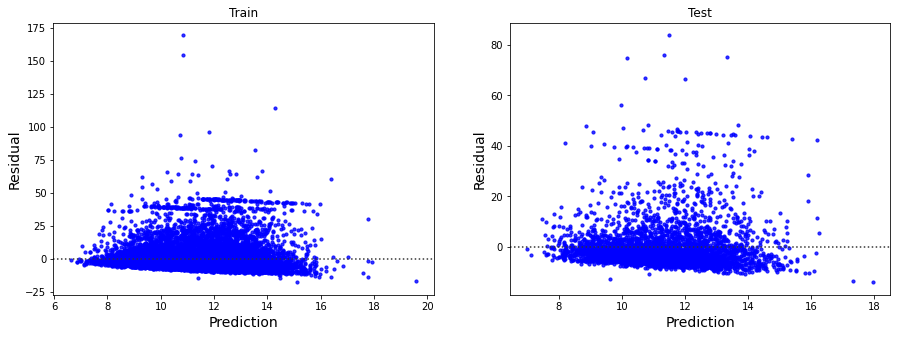

In [14]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual
plot_residual(X_train, y_train, X_test, y_test, model)

# feature importance

selama model jelek, jangan pake feature importance

# evaluation

### actual vs prediction plot

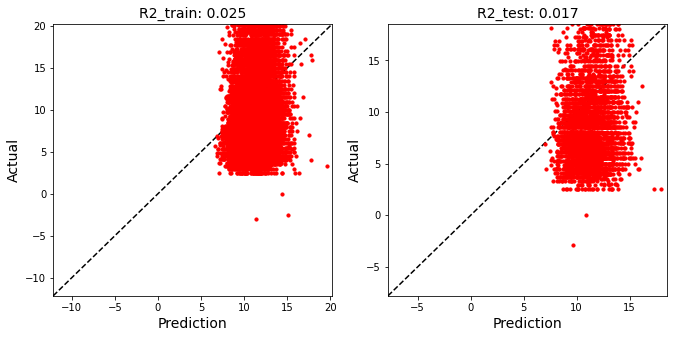

In [15]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

# coba transform

In [16]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax", poly=2, transform="yeo-johnson"), ['passenger_count', 'year', 'Distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['weekday', 'weekend', 'day','month', 'hour']),
])

from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__fit_intercept': False, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7201432840331174 0.7148593907185042 0.7453929042134977


C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


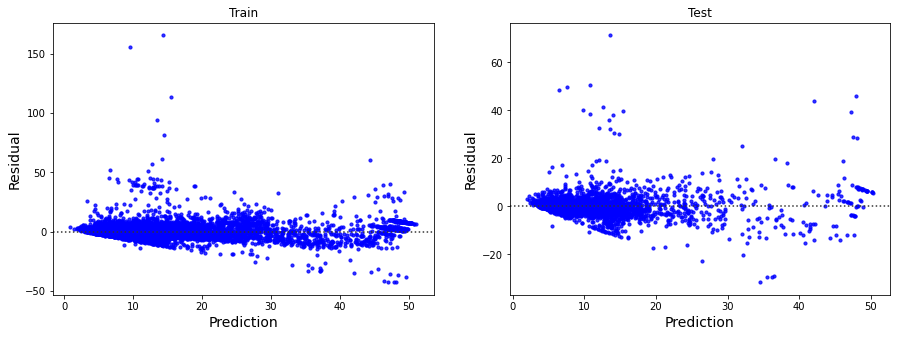

In [17]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual
plot_residual(X_train, y_train, X_test, y_test, model)

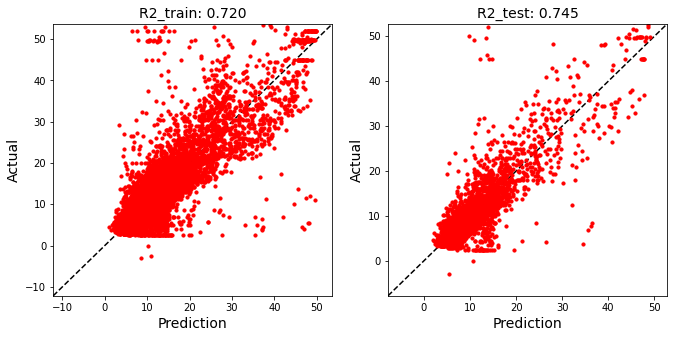

In [18]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

In [19]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax", poly=2, transform="yeo-johnson"), ['passenger_count', 'year', 'Distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['weekday', 'weekend', 'day','month', 'hour']),
])

from xgboost import XGBRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__colsample_bytree': 0.547523655303147, 'algo__gamma': 1, 'algo__learning_rate': 0.019777612333286093, 'algo__max_depth': 8, 'algo__n_estimators': 180, 'algo__reg_alpha': 0.011671429662074233, 'algo__reg_lambda': 8.062316132568979, 'algo__subsample': 0.5055185066591157, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': True}
0.7957812870497885 0.7241453419852403 0.7544066148107321


In [20]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax", poly=2, transform="yeo-johnson"), ['passenger_count', 'year', 'Distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['weekday', 'weekend', 'day','month', 'hour']),
])

from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__max_depth': 34, 'algo__max_features': 0.19980173873064822, 'algo__min_samples_leaf': 13, 'algo__n_estimators': 150, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7652755450509662 0.723257656416337 0.7563500162822676


In [21]:
df.skew()

fare_amount         3.478679
passenger_count     2.034311
hour               -0.421211
day                 0.017825
weekday            -0.032754
weekend             0.941647
month               0.117350
year                0.062988
Distance           35.182047
dtype: float64